# <a name="0"><font color='Blue'>**Rossmann Store Sales**</font></a>
## **A Time Series problem.**
### The competition page from [this](https://www.kaggle.com/competitions/rossmann-store-sales) link.

---

## **Description:**

**Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.
In their first Kaggle competition, Rossmann is challenging you to predict 6 weeks of daily sales for 1,115 stores located across Germany. Reliable sales forecasts enable store managers to create effective staff schedules that increase productivity and motivation. By helping Rossmann create a robust prediction model, you will help store managers stay focused on what’s most important to them: their customers and their teams**


---

## **Table of Contents of the notebook:**

1. <a href="#1">**Setup**</a>
2. <a href="#2">**Reading the dataset**</a>
3. <a href="#3">**Data Preperation**</a>
4. <a href="#4">**Train Test Split**</a>
5. <a href="#5">**Gaining Insights (EDA)**</a>
6. <a href="#6">**Time Series Models**</a>
7. <a href="#7">**Machine Leaning Model**</a>
8. <a href="#8">**Choosing Best Model**</a>
9. <a href="#8">**Kaggle submission**</a>

---

# 1. <a name="1">**Setup**</a>
(<a href="#0">Go to top</a>)

**Installing and Importing used libraries.**

In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
from joblib import Parallel, delayed
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.stattools import kpss,adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from prophet import Prophet
#logging.getLogger("cmdstanpy").disabled = True
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
from itertools import product
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.tsa as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import statsmodels.api as sm
import scipy.stats as scs

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
plt.rcParams['figure.figsize'] = 25, 8


---

# 2. <a name="2">**Reading the dataset**</a>
(<a href="#0">Go to top</a>)

In [2]:
df = pd.read_csv(r"D:\ITI\time series\rossmann-store-sales\train.csv")

In [3]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


---

# 3. <a name="3">**Data preperation**</a>
(<a href="#0">Go to top</a>)

## A- Choose The Store We will work on (Store 1)

In [5]:
df = df[df["Store"] == 1]

## B- Check for nulls

In [6]:
df.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

## C- Make freq as daily

In [7]:
df = pd.DataFrame(df)

# Convert 'Date' to datetime with the correct format
df["Date"] = pd.to_datetime(df["Date"], format='%Y-%m-%d')

# Set 'Date' as the index
df = df.set_index("Date")

In [8]:
df = df.asfreq('D')

In [9]:
df.isnull().sum()

Store            0
DayOfWeek        0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

## D- Remove Customers column as it won't be available in production

In [10]:
df.drop(["Customers"], axis=1,inplace=True)

---

# 4. <a name="4">**Train Test Split**</a>
(<a href="#0">Go to top</a>)

### <font color='green'>**Split data into train and test 80:20**</font>

In [11]:
train_size = int(len(df) * 0.8)
train_data = df[:train_size].copy(deep=True)
test_data = df[train_size:].copy(deep=True)

---

# 5. <a name="5">**Gaining Insights (EDA)**</a>
(<a href="#0">Go to top</a>)

## A- Plot Sales (All train data) 

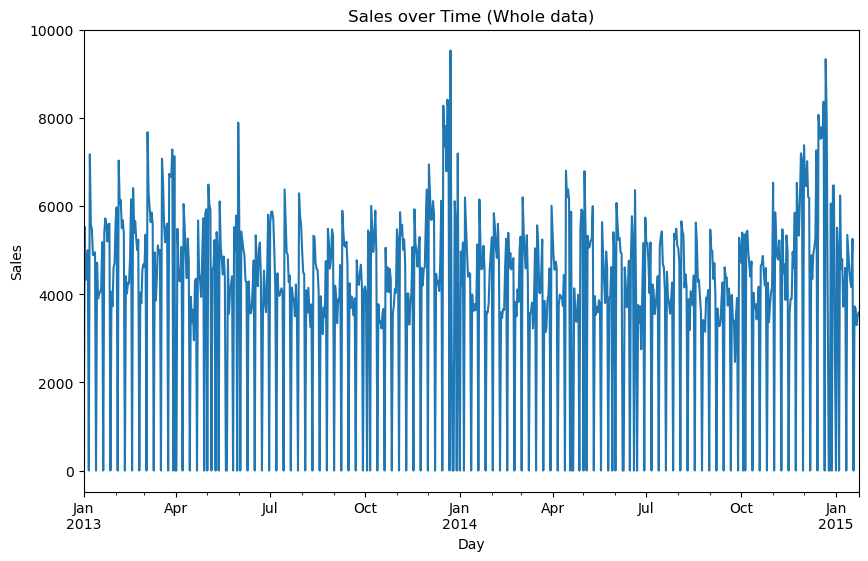

In [22]:
plt.figure(figsize=(10, 6))
train_data['Sales'].plot()
plt.xlabel('Day')
plt.ylabel('Sales')
plt.title('Sales over Time (Whole data)')
plt.show()

## B- Plot Sales (One Month) 

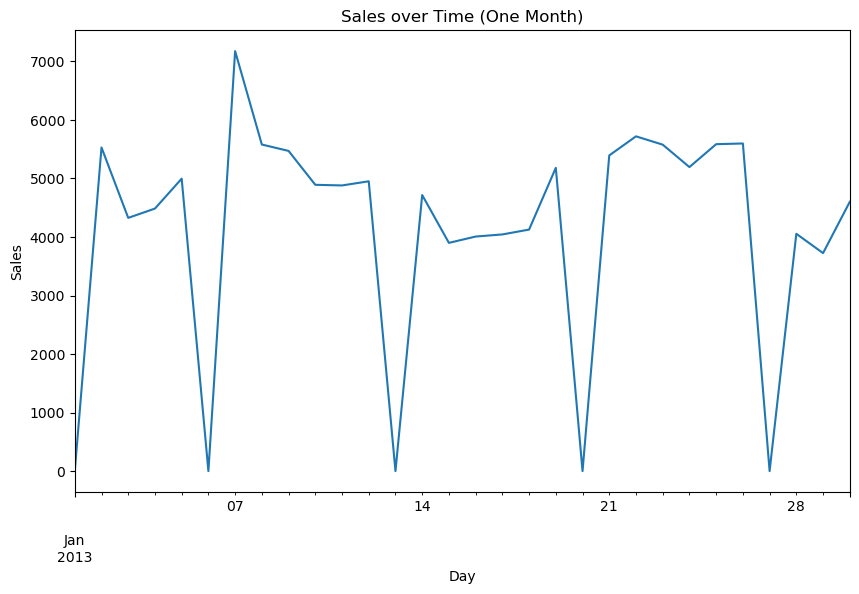

In [17]:
plt.figure(figsize=(10, 6))
train_data['Sales'][:30].plot()
plt.xlabel('Day')
plt.ylabel('Sales')
plt.title('Sales over Time (One Month)')
plt.show()

### <font color='green'>**It seems that Friday is the off day of the stores**</font>

## C- Plot Sales (One Year) 

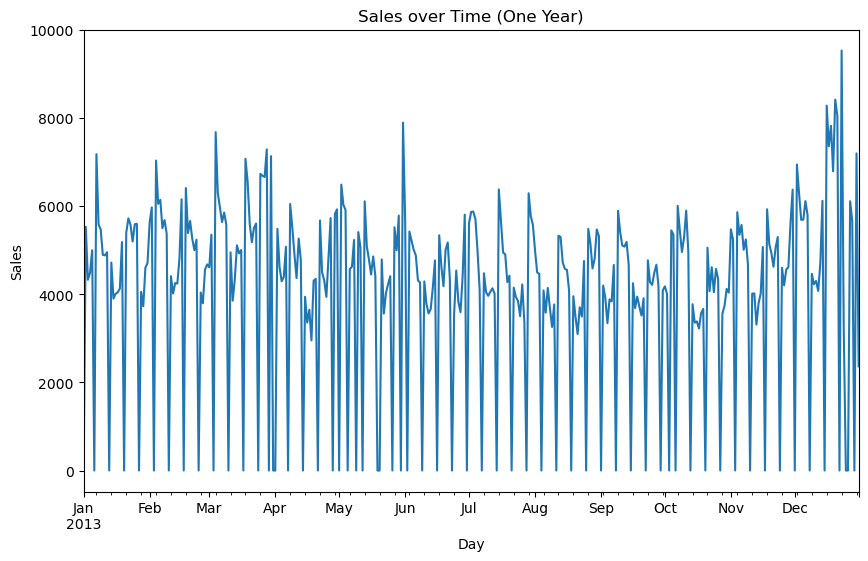

In [18]:
plt.figure(figsize=(10, 6))
train_data['Sales'][:365].plot()
plt.xlabel('Day')
plt.ylabel('Sales')
plt.title('Sales over Time (One Year)')
plt.show()

### <font color='green'>**We see a peak in sales in Dec**</font>

## D- Extract additional columns 

In [12]:
train_data['year'] = train_data.index.year
train_data['month'] = train_data.index.month
train_data['day'] = train_data.index.day

# Convert the columns to integers
train_data['year'] = train_data['year'].astype(int)
train_data['month'] = train_data['month'].astype(int)
train_data['day'] = train_data['day'].astype(int)

In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 753 entries, 2013-01-01 to 2015-01-23
Freq: D
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Store          753 non-null    int64 
 1   DayOfWeek      753 non-null    int64 
 2   Sales          753 non-null    int64 
 3   Open           753 non-null    int64 
 4   Promo          753 non-null    int64 
 5   StateHoliday   753 non-null    object
 6   SchoolHoliday  753 non-null    int64 
 7   year           753 non-null    int32 
 8   month          753 non-null    int32 
 9   day            753 non-null    int32 
dtypes: int32(3), int64(6), object(1)
memory usage: 55.9+ KB


## E- Seasonal Plots (Plot sales by different dates values)

In [24]:
5//7

0

In [25]:
12//7

1

In [26]:
19//7

2

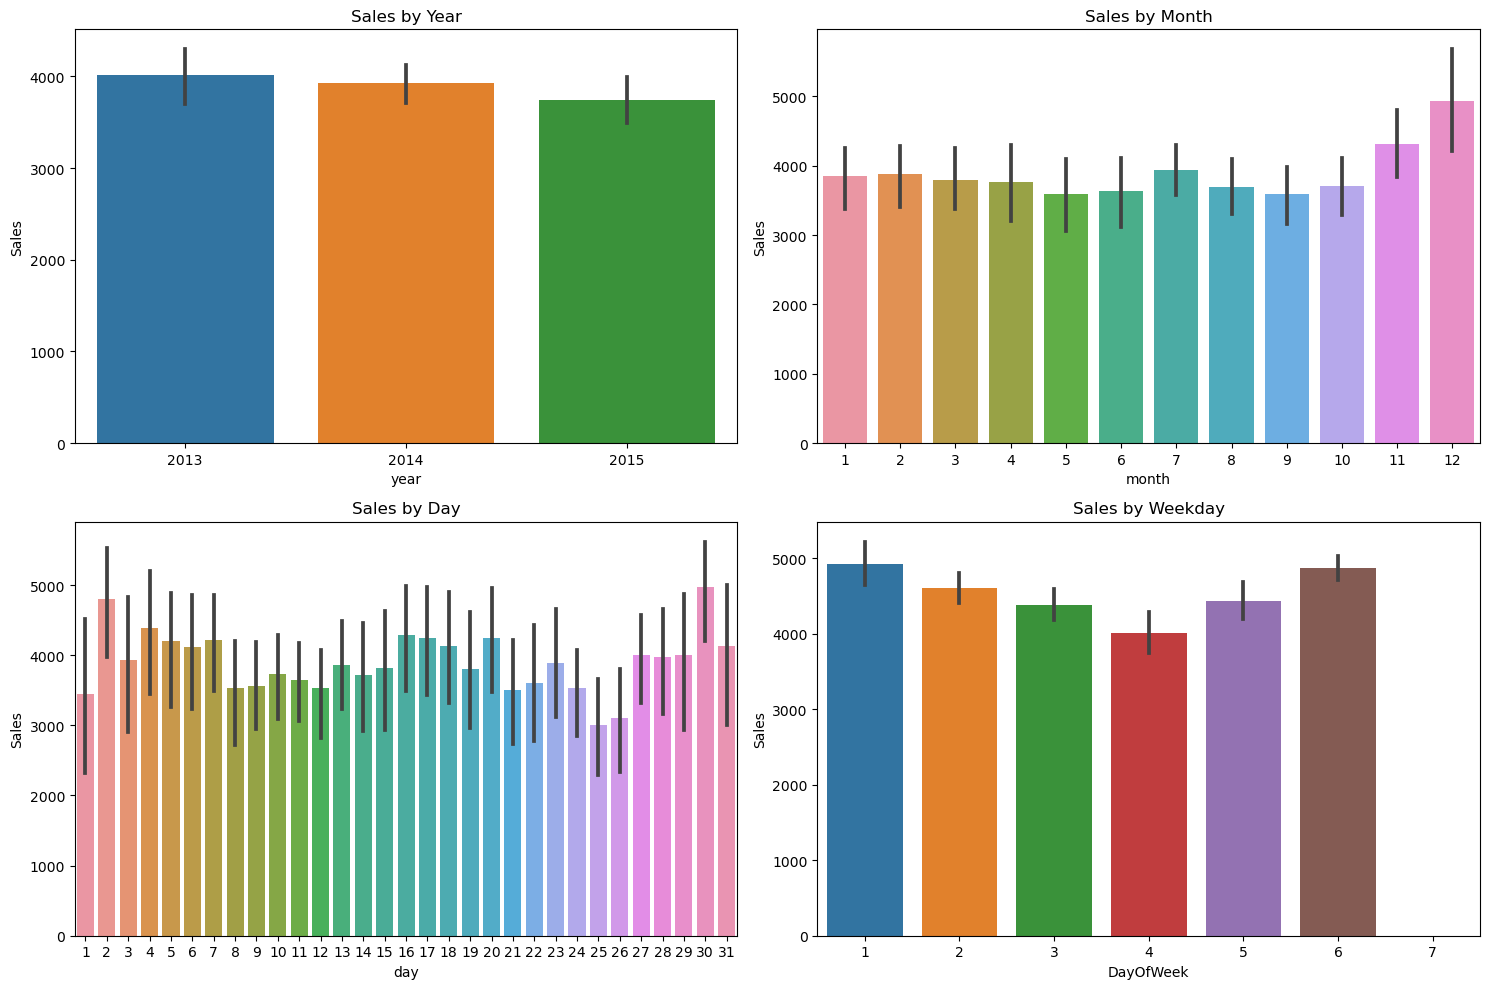

In [48]:
# Create a grid of bar charts
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.barplot(x='year',y="Sales", data=train_data, ax=axes[0, 0])
sns.barplot(x='month',y="Sales", data=train_data, ax=axes[0, 1])
sns.barplot(x='day',y="Sales", data=train_data, ax=axes[1, 0])
sns.barplot(x='DayOfWeek',y="Sales", data=train_data, ax=axes[1, 1])

# Set the titles for each chart
axes[0, 0].set_title('Sales by Year')
axes[0, 1].set_title('Sales by Month')
axes[1, 0].set_title('Sales by Day')
axes[1, 1].set_title('Sales by Weekday')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the grid of bar charts
plt.show()

### <font color='green'>**The Insighst we gained:**<Br><Br>1. Sales decrease over the years<Br><Br>2. The peak of sales is on Nov and Dec<Br><Br>3. Sales increase in the opening and closing day of the week</font>

## F- Define Monthly seasonal plot

In [22]:
def monthly_quarter_line_plot(df,col_x,col_y,hue_col,title="Monthly"):
    plt.figure(figsize=(10,8))
    sns.lineplot(data=df, 
                 x=col_x, 
                 y=col_y, 
                 hue=hue_col, 
                 legend='full',palette="tab10")

    # add title
    plt.title(title+' Seasonal plot')

    # move the legend outside of the main figure
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

## G- plot Monthly seasonal

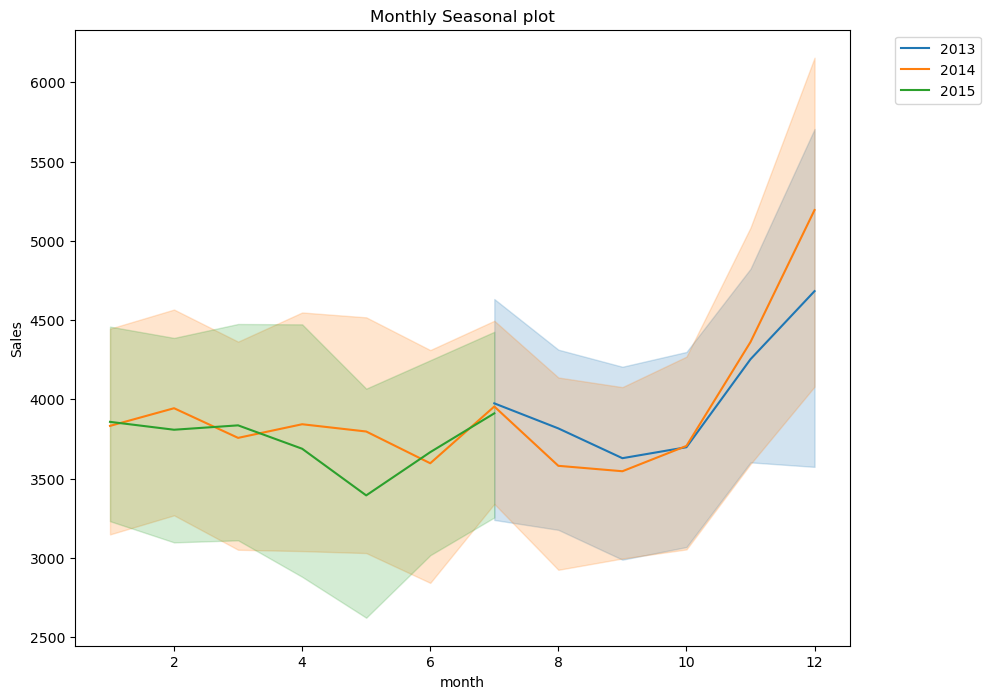

In [23]:
monthly_quarter_line_plot(train_data,"month","Sales","year",title="Monthly")

## H- Plot Sales in different conditions

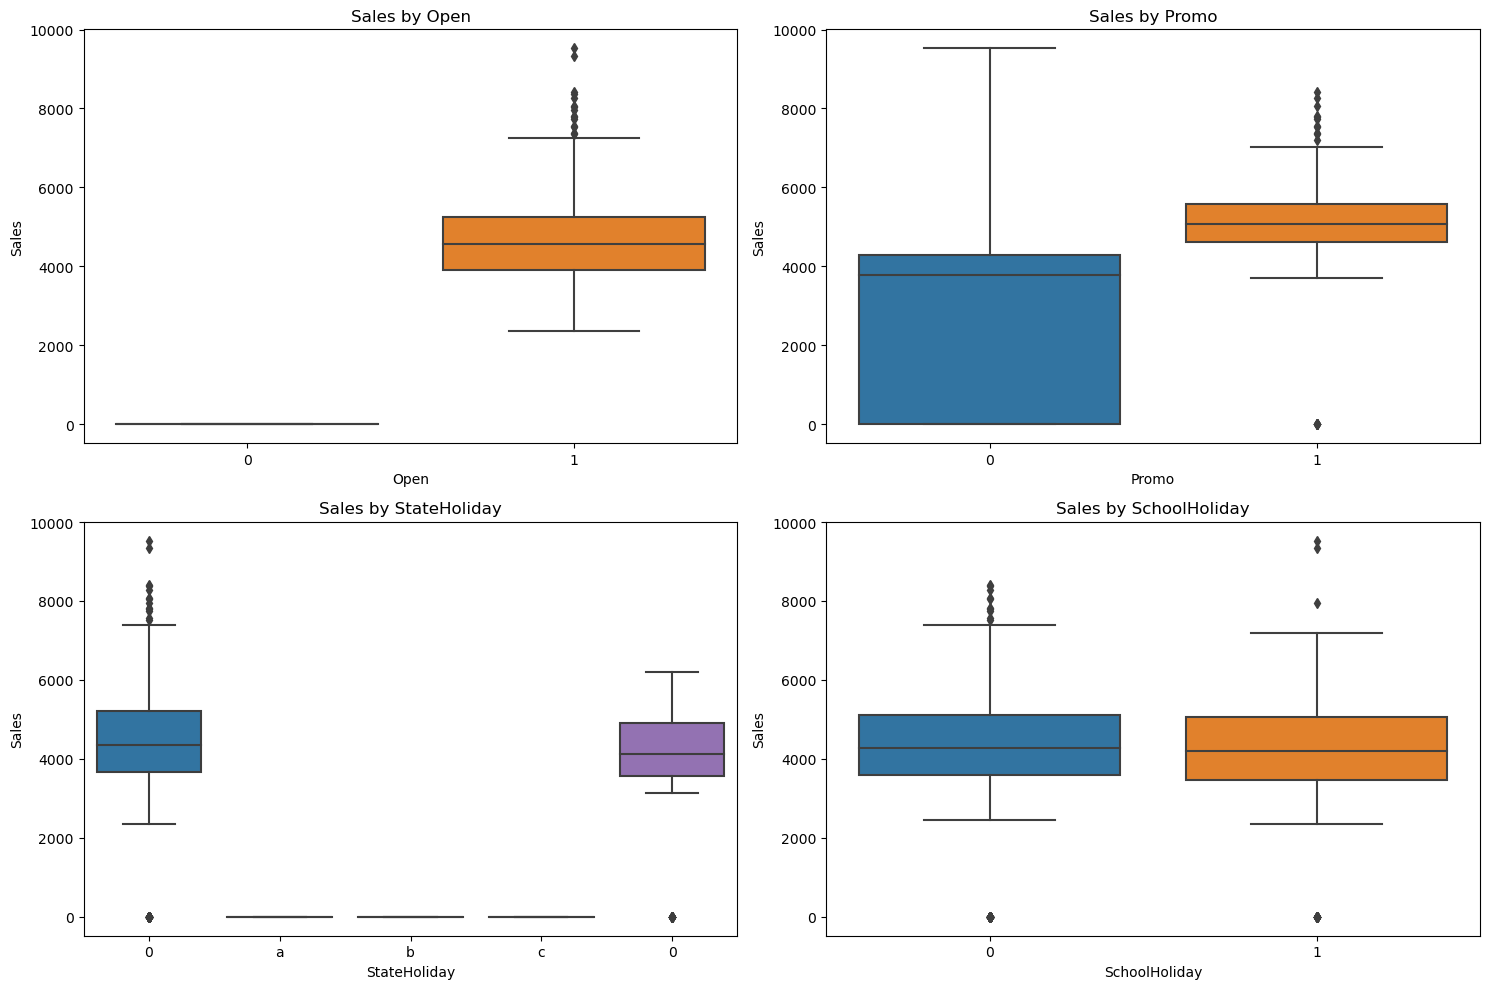

In [24]:

# Create a grid of box plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.boxplot(x='Open', y="Sales", data=train_data, ax=axes[0, 0])
sns.boxplot(x='Promo', y="Sales", data=train_data, ax=axes[0, 1])
sns.boxplot(x='StateHoliday', y="Sales", data=train_data, ax=axes[1, 0])
sns.boxplot(x='SchoolHoliday', y="Sales", data=train_data, ax=axes[1, 1])

# Set the titles for each chart
axes[0, 0].set_title('Sales by Open')
axes[0, 1].set_title('Sales by Promo')
axes[1, 0].set_title('Sales by StateHoliday')
axes[1, 1].set_title('Sales by SchoolHoliday')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the grid of box plots
plt.show()


### <font color='green'>**Nothing unusual, no sales when store is closed, State holidays don't add new information, sales increase in promo, and Shool holidays don't make that difference**</font>

## I- Define histogram function

In [25]:
def histograms(df,col_name,bins_number=100,diff=False, xmin=-1000, xmax=1000):
    if diff:
        plt.figure(figsize=(8,6))
        plt.hist(df[col_name].diff(),bins=bins_number)
        plt.xlim(xmin,xmax)
        plt.show()
    else:
        plt.figure(figsize=(8,6))
        plt.hist(df[col_name],bins=bins_number)
        plt.show()

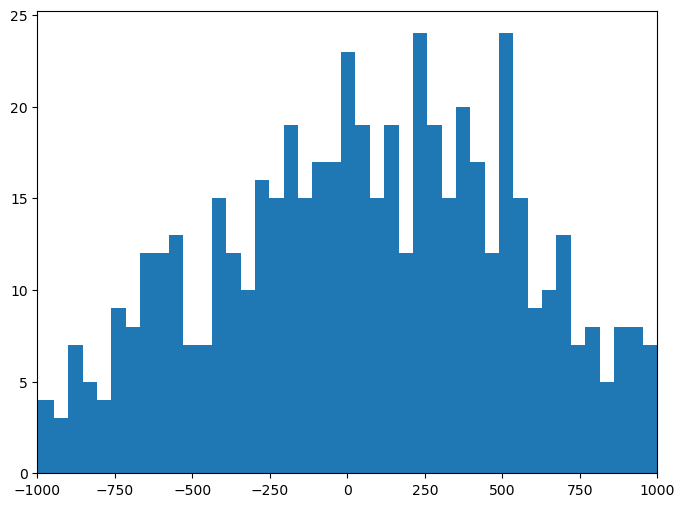

In [26]:
histograms(train_data[train_data["Sales"] != 0],"Sales",bins_number=200,diff=True)

---

# 6. <a name="6">**Time Series Models**</a>
(<a href="#0">Go to top</a>)

### Eval Metric (RMSPE):

In [14]:
def rmspe(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) / np.mean(y_true)


### Plot train vs test

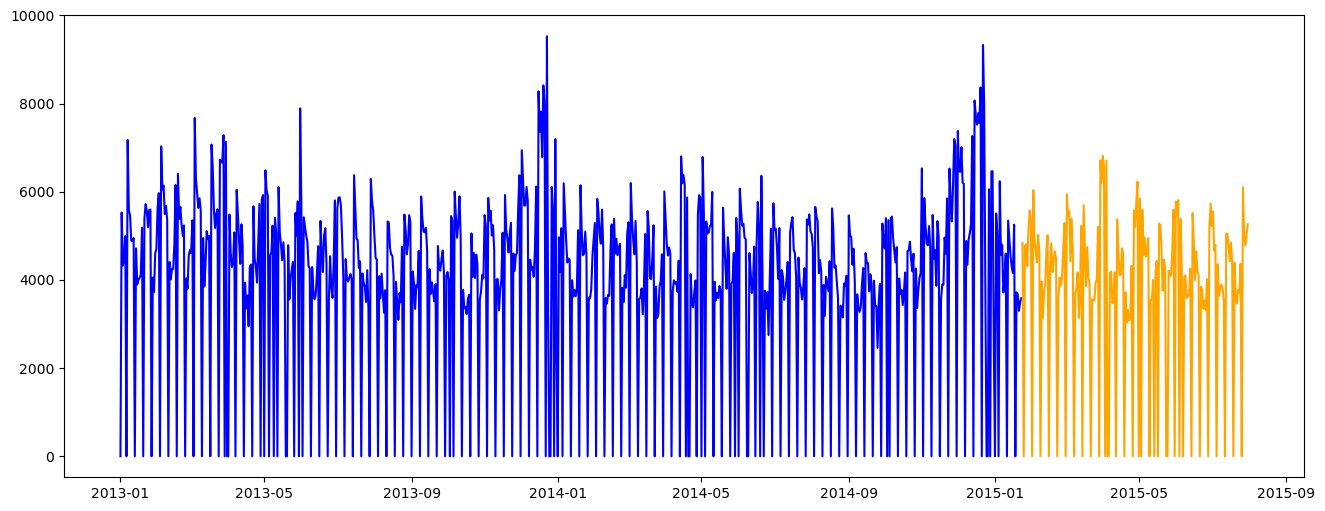

In [26]:
fig ,axes =plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(16)

axes.plot(train_data["Sales"], label='Train',color='blue')
axes.plot(test_data["Sales"], label='Test',color='orange')
plt.show()

## **A- Simple Forecasting Models**

### Models Functions

In [15]:
def average_method(train_data,test_data):
    ## Average method 
    average_prediction = [np.mean(train_data)]*len(test_data)
    average_pred = pd.DataFrame(average_prediction)
    average_pred.index = test_data.index
    return average_pred.squeeze()

def naive_method(train_data,test_data):
    ##Naive method
    naiive_prediction = [train_data.iloc[-1]]*len(test_data)
    naiive_pred = pd.DataFrame(naiive_prediction)
    naiive_pred.index = test_data.index
    return naiive_pred.squeeze()

def seasonal_naive(train_data,test_data):
    ##SEasonal_NAive
    dates = (test_data.index - np.timedelta64(1, 'Y')).values.astype('datetime64[D]')
    dates = dates + np.timedelta64(2,'D')
    seasonal_naive_prediction = train_data[train_data.index.isin(dates)].values # seasonal naive prediction
    seasonal_naive = pd.DataFrame(seasonal_naive_prediction).set_index(test_data.index)
    return seasonal_naive.squeeze()

def drift_method(train_data,test_data):
    # Get the slope
    y_t = train_data[len(train_data)-1]
    m = (y_t - train_data[1]) / len(train_data)
    h = np.linspace(0,len(test_data)-1, len(test_data))
    drift_prediction = y_t + m * h
    drift_pred = pd.DataFrame(drift_prediction).set_index(test_data.index)
    return drift_pred.squeeze()

### Get predictions

In [16]:
average_pred = average_method(train_data["Sales"],test_data["Sales"])
naiive_pred = naive_method(train_data["Sales"],test_data["Sales"])
seasonal_naive_pred = seasonal_naive(train_data["Sales"],test_data["Sales"])
drift_pred = drift_method(train_data["Sales"],test_data["Sales"])

### Make Value of prediction = 0 when The Store is not open

In [17]:
for pred in [average_pred,naiive_pred,seasonal_naive_pred,drift_pred]:
    pred[test_data["Open"] == 0] = 0

### Plot predicions

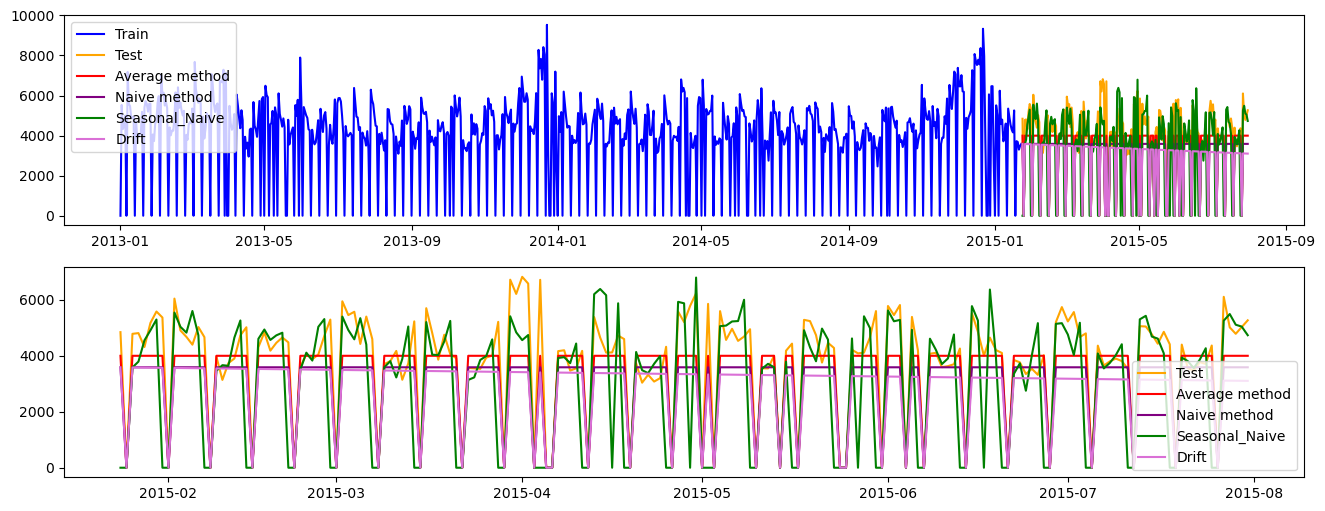

In [30]:
fig ,axes =plt.subplots(2,1)
fig.set_figheight(6)
fig.set_figwidth(16)

axes[0].plot(train_data["Sales"], label='Train',color='blue')
axes[0].plot(test_data["Sales"], label='Test',color='orange')

axes[0].plot(average_pred,label="Average method",color='red')
axes[0].plot(naiive_pred,label="Naive method",color='purple')
axes[0].plot(seasonal_naive_pred, label='Seasonal_Naive',color='green')
axes[0].plot(drift_pred,label='Drift',color='orchid')
axes[0].legend(loc='best')

axes[1].plot(test_data["Sales"], label='Test',color='orange')
axes[1].plot(average_pred,label="Average method",color='red')
axes[1].plot(naiive_pred,label="Naive method",color='purple')
axes[1].plot(seasonal_naive_pred, label='Seasonal_Naive',color='green')
axes[1].plot(drift_pred,label='Drift',color='orchid')
axes[1].legend(loc='best')
plt.show()

### Evaluate predictions

In [18]:
print(f"""
RMSPE for average method:{rmspe( average_pred, test_data[["Sales"]])}
RMSPE for Naive method:{rmspe( naiive_pred, test_data[["Sales"]])}
RMSPE for Drift method:{rmspe( drift_pred, test_data[["Sales"]])}""")


RMSPE for average method:0.2700499184008197
RMSPE for Naive method:0.3848913363901235
RMSPE for Drift method:0.47645674308932817


### <font color='green'>**Seasonal naive method is doing a very good job actually!**</font>

## **B- MSTL Model**

In [19]:
mstl = MSTL(train_data["Sales"], periods=(7, 30, 365), stl_kwargs={"seasonal_deg": 0})
res = mstl.fit() 

### <font color='green'>**Multiple seasonal periods are allowed, so we will choose weekly, monthly and anually**</font>

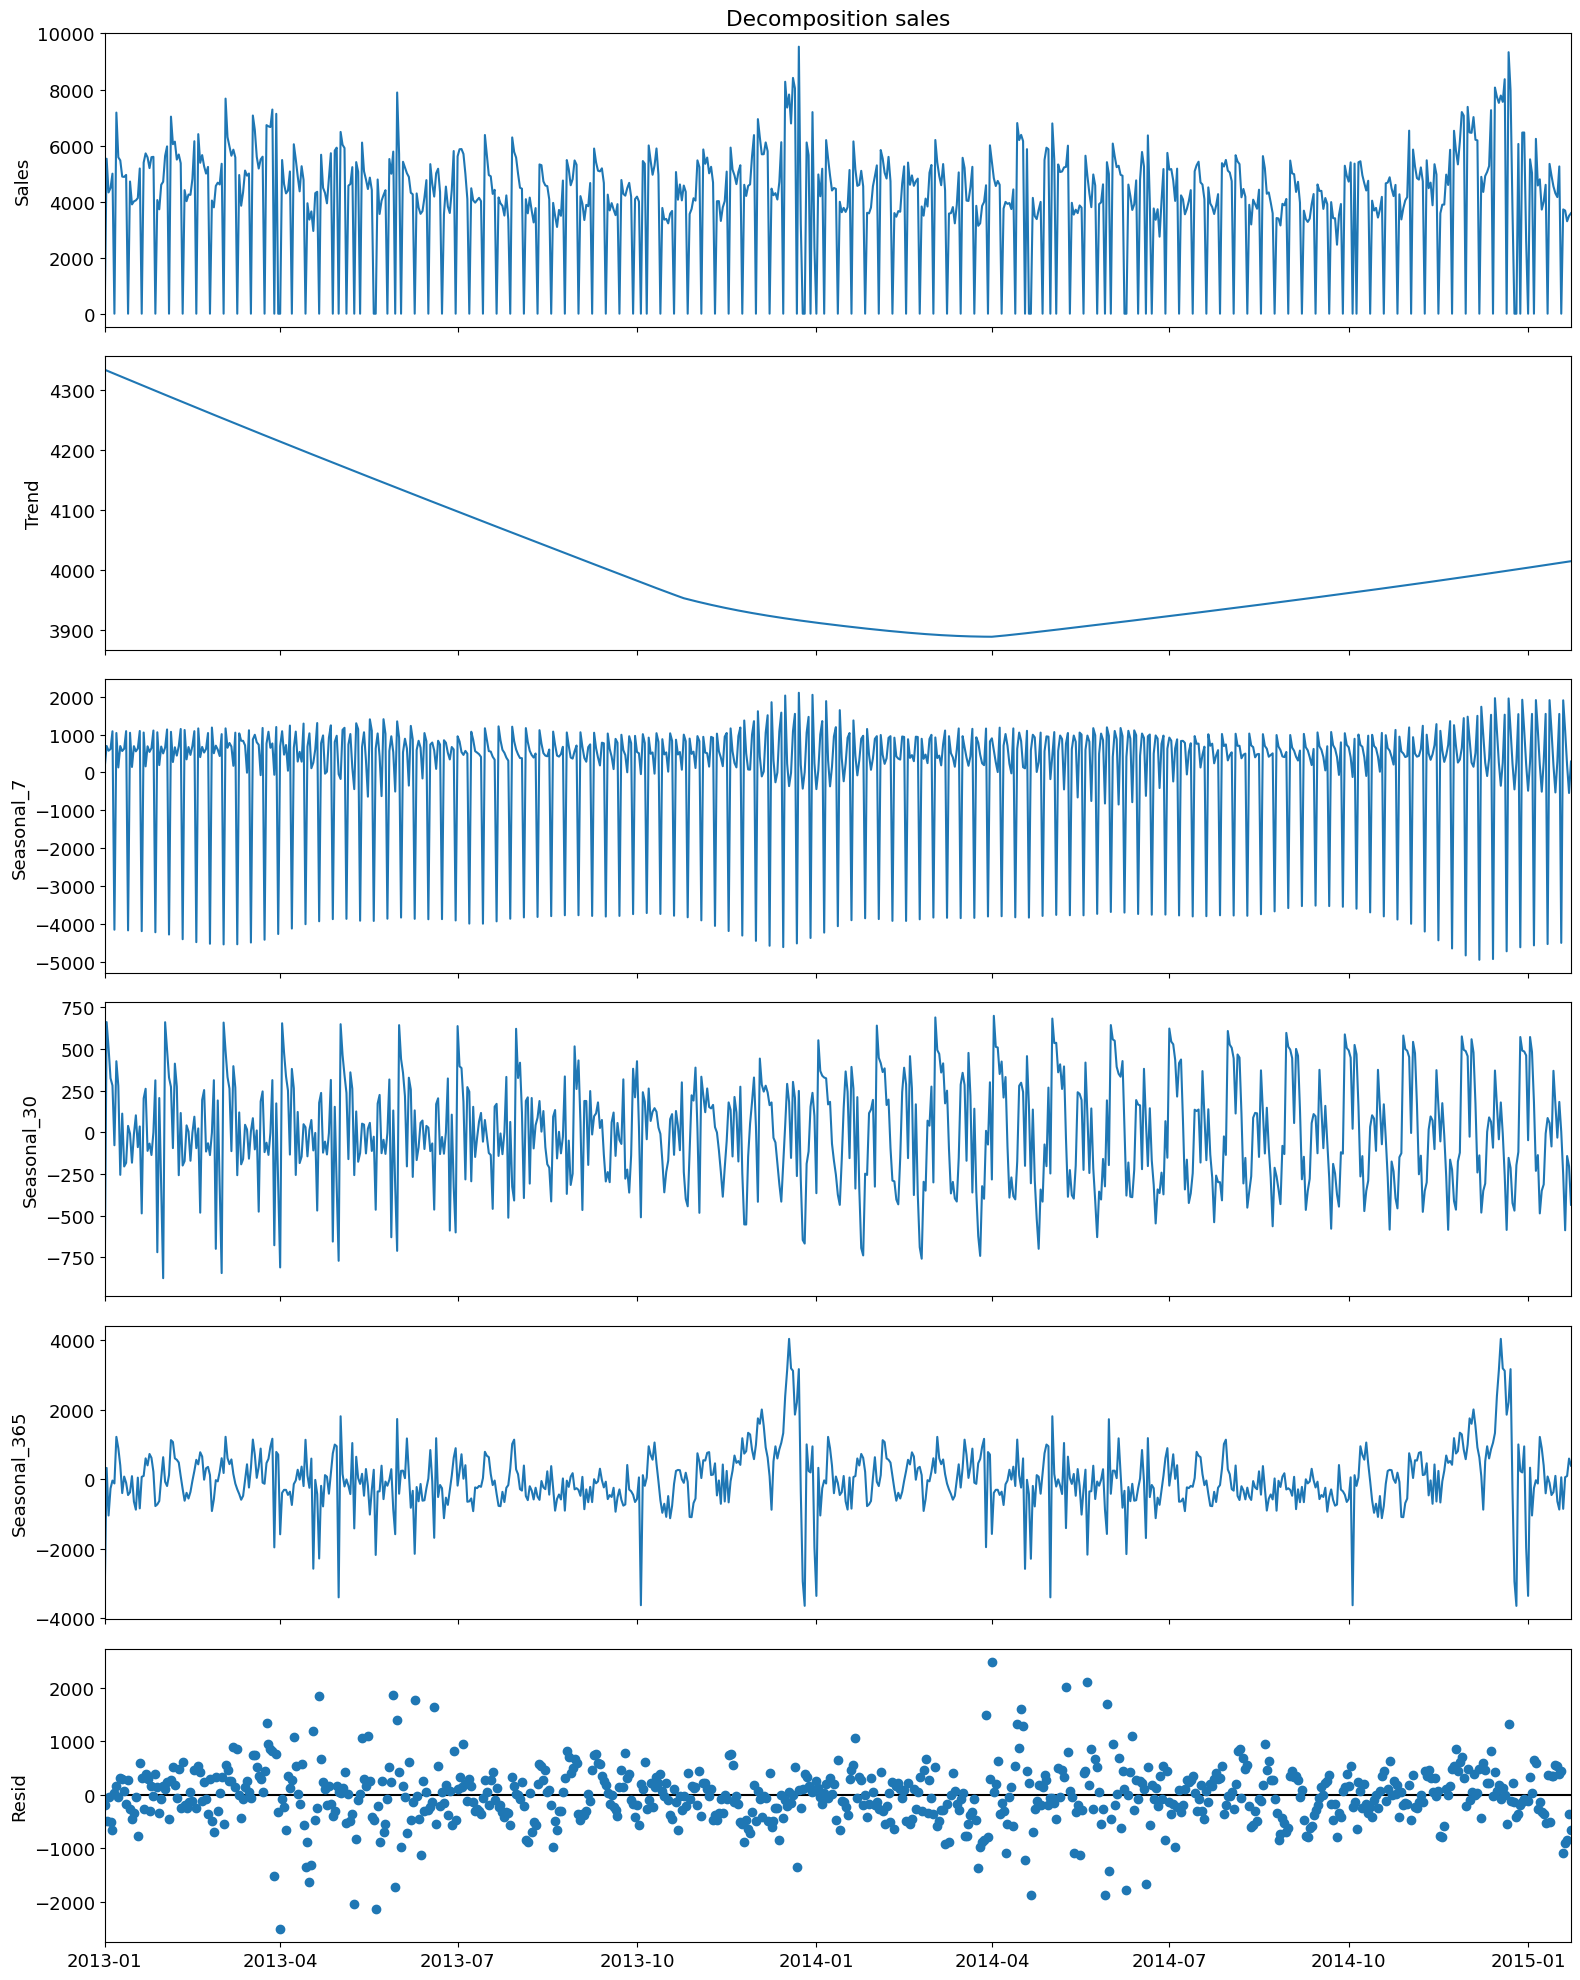

In [20]:
# Start with the plot from the results object `res`
plt.rc("figure", figsize=(16, 20))
plt.rc("font", size=13)
fig = res.plot()

# Make plot pretty
axs = fig.get_axes()

axs[0].set_ylabel("Sales")
axs[0].set_title("Decomposition sales")

plt.tight_layout()

## **C- Arima models**

### Define kpss_test function

In [21]:
def kpss_test(data,threshold=0.05,regression="c"):
    result = kpss(data,regression="c")
    #print(result)
    # Print test results
    print('KPSS Statistic:', result[0])
    print('p-value:', result[1])
    print('Lags Used:', result[2])
    print('Critical Values:')
    for key, value in result[3].items():
        print('\t{}: {}'.format(key, value))
    if result[1]<=threshold:
        print("The data is not stationary")
    else:
        print("The data is stationary")

### Define adf_test function

In [22]:
def adf_test(data,threshold=0.05):
    # Perform ADF test
    result = adfuller(data,autolag="AIC")

    # Print test results
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

    if result[1] <= threshold:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

### Define autocorrelatin_graphs function

In [23]:
def autocorrelatin_graphs(value,n_lags,title_text):
    fig, axes = plt.subplots(3,1,dpi=80)
    fig.set_figheight(12)
    fig.set_figwidth(16)
    value_plot = axes[0].plot(value)
    plt.title(f'{title_text}')
    acf_plot = plot_acf(value, lags=n_lags, title=f'Autocorrelation in {title_text}',ax=axes[1])
    plt.xlabel('Lags')
    pacf_plot = plot_pacf(value, lags=n_lags, title=f'Partial Autocorrelation in {title_text}',ax=axes[2])
    plt.xlabel('Lags')
    plt.tight_layout()
    plt.show()

### Plot Rolling mean and STD

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

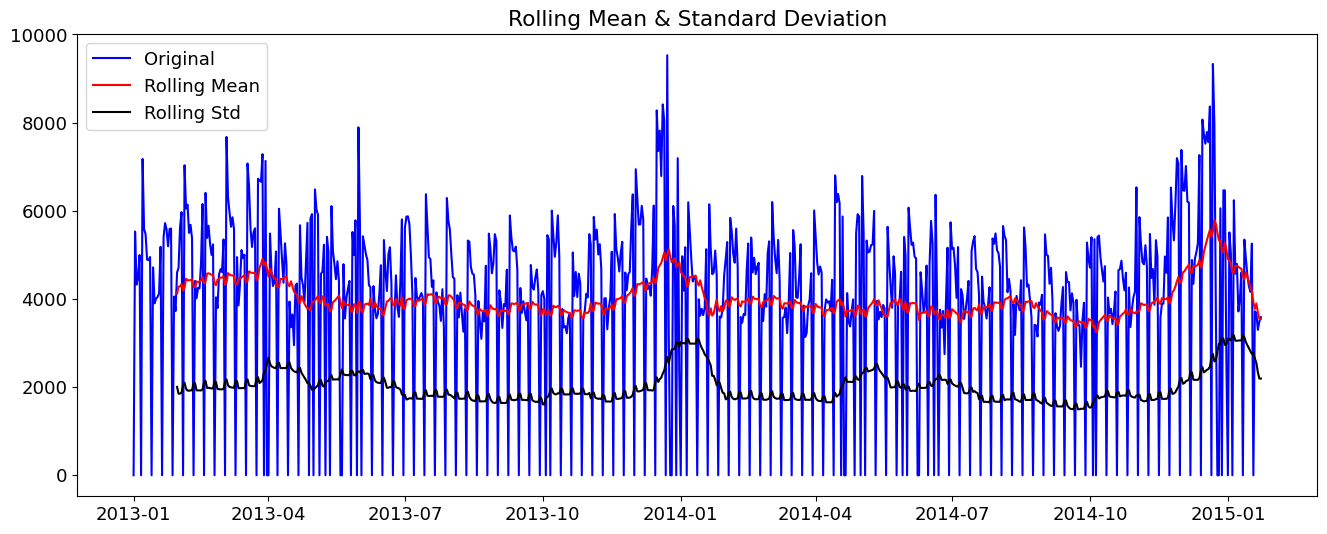

In [37]:
fig ,axes =plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(16)

#Determing rolling statistics
rolmean = train_data[["Sales"]].rolling( window=30).mean()
rolstd = train_data[["Sales"]].rolling(window=30).std()

#Plot rolling statistics:
orig = axes.plot(train_data[["Sales"]], color='blue',label='Original')
mean = axes.plot(rolmean, color='red', label='Rolling Mean')
std = axes.plot(rolstd, color='black', label = 'Rolling Std')
axes.legend(loc='best')
axes.set_title('Rolling Mean & Standard Deviation')

### Check stationarity:

In [24]:
adf_test(train_data[["Sales"]])

ADF Statistic: -3.6278645835415664
p-value: 0.0052501251049467046
Critical Values:
	1%: -3.439314999916068
	5%: -2.8654965012008677
	10%: -2.5688768817372867
Conclusion:====>
Reject the null hypothesis
Data is stationary


In [25]:
kpss_test(train_data[["Sales"]])

KPSS Statistic: 0.2099586392870777
p-value: 0.1
Lags Used: 3
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
The data is stationary


### Autocorrelatin Graphs

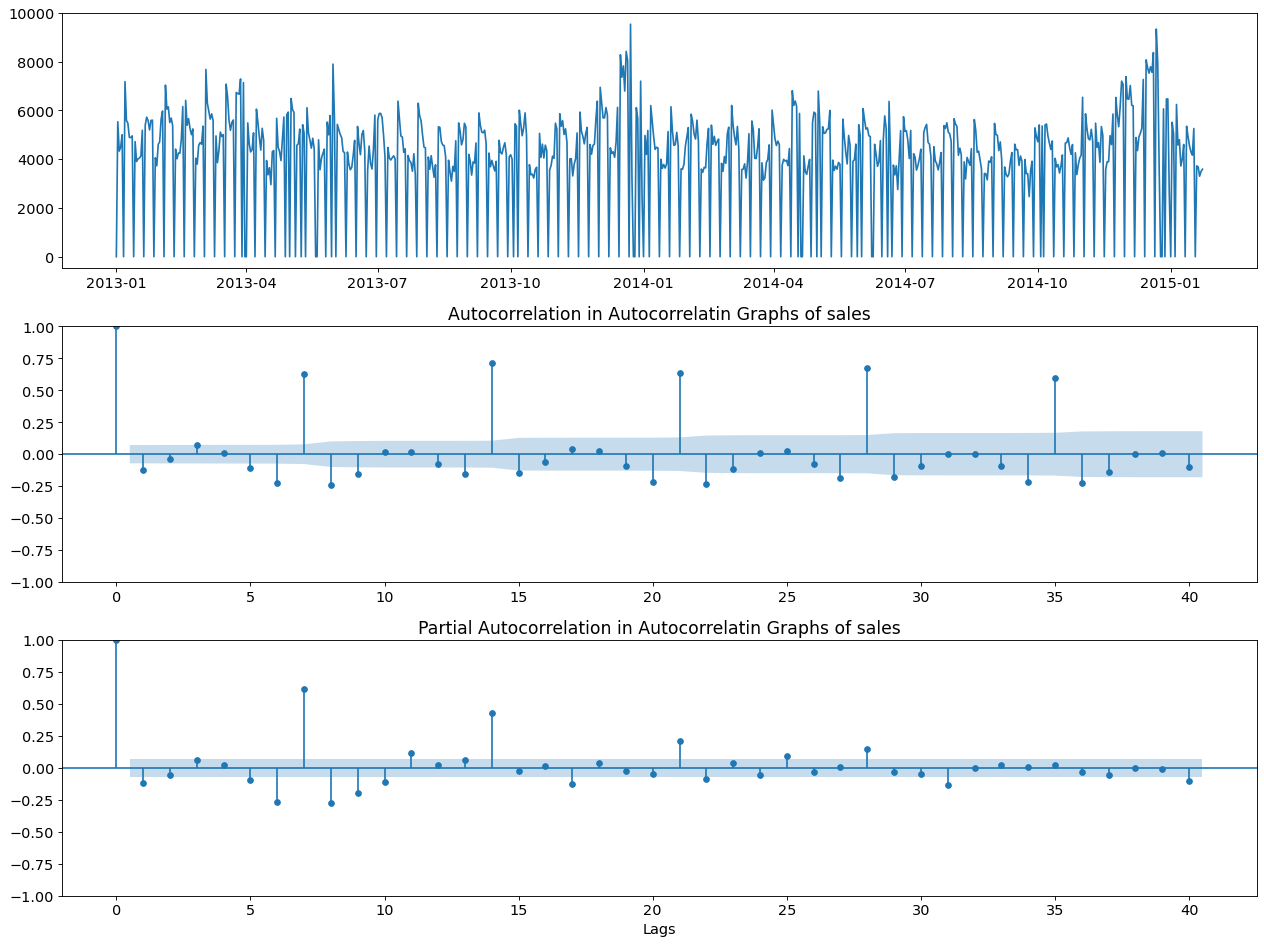

In [40]:
autocorrelatin_graphs(train_data[["Sales"]], n_lags=40, title_text="Autocorrelatin Graphs of sales")

### Arima

In [26]:
# fit model
ARIMA_model = ARIMA(train_data[["Sales"]], order=(1, 1, 1))
ARIMA_model_fit = ARIMA_model.fit()

In [27]:
ARIMA_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  753
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6799.437
Date:                Sun, 09 Jun 2024   AIC                          13604.874
Time:                        17:50:32   BIC                          13618.742
Sample:                    01-01-2013   HQIC                         13610.217
                         - 01-23-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1163      0.035     -3.347      0.001      -0.184      -0.048
ma.L1         -0.9999      0.079    -12.729      0.000      -1.154      -0.846
sigma2      4.142e+06   3.15e+05     13.162      0.000    3.53e+06    4.76e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                75.70
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                            -0.77
Prob(H) (two-sided):                  0.75   Kurtosis:                         3.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
start_index = test_data.index.min()
end_index = test_data.index.max()

#Predictions
arima_preds = ARIMA_model_fit.predict(start=start_index, end=end_index)

### Make Value of prediction = 0 when The Store is not open

In [29]:
arima_preds[test_data["Open"] == 0] = 0

### Evaluate performance

In [30]:
print(f'RMSPE for Arima on test:{rmspe(arima_preds,test_data[["Sales"]])}')

RMSPE for Arima on test:0.2707639709229417


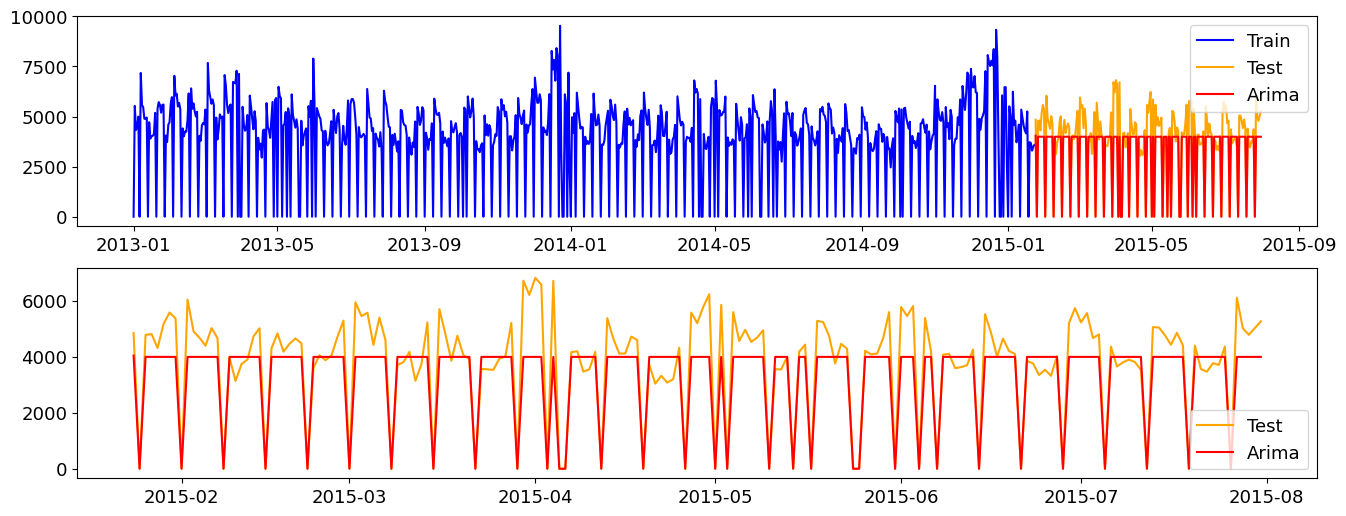

In [47]:
fig ,axes =plt.subplots(2,1)
fig.set_figheight(6)
fig.set_figwidth(16)

axes[0].plot(train_data["Sales"], label='Train',color='blue')
axes[0].plot(test_data["Sales"], label='Test',color='orange')

axes[0].plot(arima_preds,label="Arima",color='red')
axes[0].legend(loc='best')

axes[1].plot(test_data["Sales"], label='Test',color='orange')
axes[1].plot(arima_preds,label="Arima",color='red')
axes[1].legend(loc='best')
plt.show()

### SARIMAX

In [31]:
# fit model
SARIMAX_model = SARIMAX(train_data[["Sales"]], order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
SARIMAX_model_fit = SARIMAX_model.fit()

In [32]:
SARIMAX_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Sales   No. Observations:                  753
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -6330.115
Date:                           Sun, 09 Jun 2024   AIC                          12670.231
Time:                                   17:50:44   BIC                          12693.298
Sample:                               01-01-2013   HQIC                         12679.122
                                    - 01-23-2015                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2120      0.020     10.814      0.000       0.174       0.250
ma.L1         -0.9484      0.010    -98.184      0.000      -0.967      -0.929
ar.S.L7       -0.0742      0.028     -2.630      0.009      -0.130      -0.019
ma.S.L7       -0.9984      0.200     -4.994      0.000      -1.390      -0.607
sigma2      1.339e+06   2.54e+05      5.269      0.000    8.41e+05    1.84e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):              1579.10
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -1.43
Prob(H) (two-sided):                  0.97   Kurtosis:                         9.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.36e+14. Standard errors may be unstable.
"""

In [33]:
start_index = test_data.index.min()
end_index = test_data.index.max()

#Predictions
SARIMAX_preds = SARIMAX_model_fit.predict(start=start_index, end=end_index)

### Make Value of prediction = 0 when The Store is not open

In [34]:
SARIMAX_preds[test_data["Open"] == 0] = 0

In [35]:
print(f'RMSPE for SARIMAX on test:{rmspe(SARIMAX_preds,test_data[["Sales"]])}')

RMSPE for SARIMAX on test:0.19483703526123156


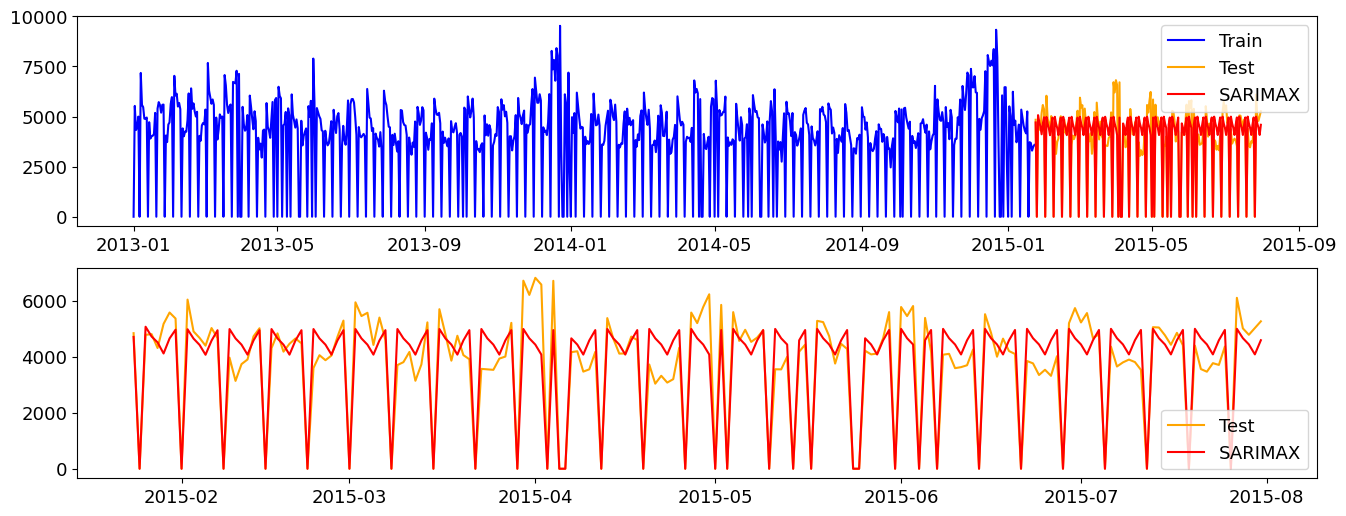

In [60]:
fig ,axes =plt.subplots(2,1)
fig.set_figheight(6)
fig.set_figwidth(16)

axes[0].plot(train_data["Sales"], label='Train',color='blue')
axes[0].plot(test_data["Sales"], label='Test',color='orange')

axes[0].plot(SARIMAX_preds,label="SARIMAX",color='red')
axes[0].legend(loc='best')

axes[1].plot(test_data["Sales"], label='Test',color='orange')
axes[1].plot(SARIMAX_preds,label="SARIMAX",color='red')
axes[1].legend(loc='best')
plt.show()

### Auto Arima

In [36]:
stepwise_model = auto_arima(train_data[["Sales"]],start_p=1, start_q=1,d=1, max_p=3, max_q=3,
                            seasonal=True, start_P =1, start_Q=1, D=1, max_Q=3, max_P=3, max_order=12, m=7,
                            trace=True,stationary=True,error_action='ignore',
                            suppress_warnings=True, stepwise=True)
stepwise_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=4.18 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=13621.052, Time=0.09 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=13483.023, Time=1.69 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=13446.503, Time=1.19 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=14803.470, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=13611.017, Time=0.56 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=3.83 sec
 ARIMA(0,0,1)(0,0,2)[7] intercept   : AIC=13269.196, Time=2.15 sec
 ARIMA(0,0,1)(1,0,2)[7] intercept   : AIC=13266.485, Time=3.88 sec
 ARIMA(0,0,1)(2,0,2)[7] intercept   : AIC=13215.211, Time=4.91 sec
 ARIMA(0,0,1)(2,0,1)[7] intercept   : AIC=inf, Time=4.19 sec
 ARIMA(0,0,1)(3,0,2)[7] intercept   : AIC=inf, Time=9.29 sec
 ARIMA(0,0,1)(2,0,3)[7] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(1,0,3)[7] intercept   : AIC=13194.781, Time=6.54 sec
 ARIMA(0,0,1)(0,0,3)[7] intercept   : AIC=13199.21

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                         
=================================================================================================
Dep. Variable:                                         y   No. Observations:                  753
Model:             SARIMAX(1, 0, 1)x(1, 0, [1, 2, 3], 7)   Log Likelihood               -6567.099
Date:                                   Sun, 09 Jun 2024   AIC                          13150.199
Time:                                           17:53:40   BIC                          13187.191
Sample:                                       01-01-2013   HQIC                         13164.450
                                            - 01-23-2015                                         
Covariance Type:                                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4315.5459    738.439      5.844      0.000    2868.231    5762.861
ar.L1         -0.9397      0.146     -6.427      0.000      -1.226      -0.653
ma.L1          0.9223      0.155      5.961      0.000       0.619       1.226
ar.S.L7        0.5281      0.071      7.434      0.000       0.389       0.667
ma.S.L7       -0.1066      0.078     -1.369      0.171      -0.259       0.046
ma.S.L14       0.2920      0.042      7.015      0.000       0.210       0.374
ma.S.L21       0.1358      0.049      2.793      0.005       0.041       0.231
sigma2      2.087e+06   8.97e+04     23.266      0.000    1.91e+06    2.26e+06
===================================================================================
Ljung-Box (L1) (Q):                  17.43   Jarque-Bera (JB):               116.49
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                            -0.46
Prob(H) (two-sided):                  0.96   Kurtosis:                         4.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
length = len(test_data)

#Predictions
auto_arima_forecast,conf_int = stepwise_model.predict(n_periods=length,return_conf_int=True)

### Make Value of prediction = 0 when The Store is not open

In [38]:
auto_arima_forecast[test_data["Open"] == 0] = 0

In [39]:
print(f'RMSPE for Auto Arima on test:{rmspe(auto_arima_forecast,test_data[["Sales"]])}')

RMSPE for Auto Arima on test:0.20014754370236784


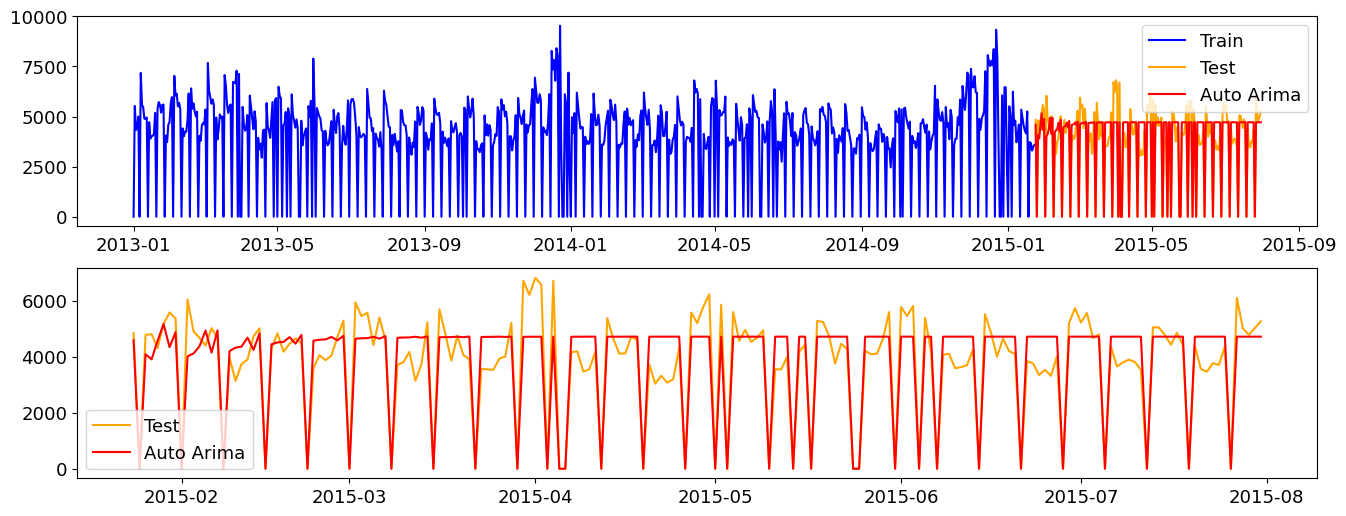

In [64]:
fig ,axes =plt.subplots(2,1)
fig.set_figheight(6)
fig.set_figwidth(16)

axes[0].plot(train_data["Sales"], label='Train',color='blue')
axes[0].plot(test_data["Sales"], label='Test',color='orange')

axes[0].plot(auto_arima_forecast,label="Auto Arima",color='red')
axes[0].legend(loc='best')

axes[1].plot(test_data["Sales"], label='Test',color='orange')
axes[1].plot(auto_arima_forecast,label="Auto Arima",color='red')
axes[1].legend(loc='best')
plt.show()

# 6. <a name="7">**Machine Learning model**</a>
(<a href="#0">Go to top</a>)

In [12]:
train_size = int(len(df) * 0.8)
train_data = df[:train_size].copy(deep=True)
test_data = df[train_size:].copy(deep=True)

### Prepare df function

In [13]:
def prepare_df_ml(df):
    new_df = df.copy(deep=True)
    new_df.drop(["Store","StateHoliday"], inplace=True, axis=1)
    new_df['Day'] = new_df.index.day.astype(int)
    new_df['Month'] = new_df.index.month.astype(int)
    new_df['Year'] = new_df.index.year.astype(int)
    new_df['DayOfYear'] = new_df.index.dayofyear.astype(int)
    new_df['WeekOfYear'] = new_df.index.isocalendar().week.astype(int)
    df_prep_X = new_df.drop("Sales", axis=1)
    df_prep_Y = new_df["Sales"]
    return df_prep_X, df_prep_Y

### Prepare training data

In [14]:
train_prep_X, train_prep_Y = prepare_df_ml(train_data)

In [15]:
train_prep_X.head()

,DayOfWeek,Open,Promo,SchoolHoliday,Day,Month,Year,DayOfYear,WeekOfYear
Date,,,,,,,,,
2013-01-01,2,0,0,1,1,1,2013,1,1
2013-01-02,3,1,0,1,2,1,2013,2,1
2013-01-03,4,1,0,1,3,1,2013,3,1
2013-01-04,5,1,0,1,4,1,2013,4,1
2013-01-05,6,1,0,1,5,1,2013,5,1


In [16]:
train_prep_Y

Date
2013-01-01       0
2013-01-02    5530
2013-01-03    4327
2013-01-04    4486
2013-01-05    4997
              ... 
2015-01-19    3721
2015-01-20    3680
2015-01-21    3299
2015-01-22    3492
2015-01-23    3586
Freq: D, Name: Sales, Length: 753, dtype: int64

### Model fitting

In [17]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor(random_state=42)


In [18]:
train_prep_X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 753 entries, 2013-01-01 to 2015-01-23
Freq: D
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   DayOfWeek      753 non-null    int64
 1   Open           753 non-null    int64
 2   Promo          753 non-null    int64
 3   SchoolHoliday  753 non-null    int64
 4   Day            753 non-null    int32
 5   Month          753 non-null    int32
 6   Year           753 non-null    int32
 7   DayOfYear      753 non-null    int32
 8   WeekOfYear     753 non-null    int32
dtypes: int32(5), int64(4)
memory usage: 44.1 KB


In [19]:
xgb_model.fit(train_prep_X, train_prep_Y)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

### Performance on train

In [20]:
xgb_train_preds = xgb_model.predict(train_prep_X)
xgb_train_preds = pd.Series(xgb_train_preds, index=train_prep_X.index)

xgb_train_preds = xgb_train_preds.clip(lower=0)
xgb_train_preds[train_prep_X["Open"] == 0] = 0
rmspe_xgb_train = rmspe(train_prep_Y, xgb_train_preds)
print(f'RMSPE for XGBoost on Train: {rmspe_xgb_train}')

RMSPE for XGBoost on Train: 0.01515925893532778


### Prepare testing data

In [21]:
test_prep_X, test_prep_Y = prepare_df_ml(test_data)

In [22]:
test_prep_X

,DayOfWeek,Open,Promo,SchoolHoliday,Day,Month,Year,DayOfYear,WeekOfYear
Date,,,,,,,,,
2015-01-24,6,1,0,0,24,1,2015,24,4
2015-01-25,7,0,0,0,25,1,2015,25,4
2015-01-26,1,1,1,0,26,1,2015,26,5
2015-01-27,2,1,1,0,27,1,2015,27,5
2015-01-28,3,1,1,0,28,1,2015,28,5
...,...,...,...,...,...,...,...,...,...
2015-07-27,1,1,1,1,27,7,2015,208,31
2015-07-28,2,1,1,1,28,7,2015,209,31
2015-07-29,3,1,1,1,29,7,2015,210,31


In [23]:
xgb_preds = xgb_model.predict(test_prep_X)

### Performance on test

In [24]:
xgb_test_preds = xgb_model.predict(test_prep_X)
xgb_test_preds = pd.Series(xgb_test_preds, index=test_prep_X.index)
xgb_test_preds = xgb_test_preds.clip(lower=0)
xgb_test_preds[test_prep_X["Open"] == 0] = 0
rmspe_xgb = rmspe(xgb_test_preds, test_prep_Y)

print(f'RMSPE for XGBoost on Test: {rmspe_xgb}')

RMSPE for XGBoost on Test: 0.1257105792685757


### Plot predictions

### Fine Tuning

In [25]:
from xgboost import XGBRegressor
from itertools import product
from tqdm import tqdm
import numpy as np

# Define the parameter grid for grid search
param_grid = {
    'learning_rate': [0.01, 0.1],  # Learning rate for boosting
    'n_estimators': [100, 200, 300],  # Number of boosting iterations
    'reg_alpha': [0.0, 0.1, 0.5],  # L1 regularization term on weights
    'reg_lambda': [0.0, 0.1, 0.5],  # L2 regularization term on weights
    'max_depth': [3, 5, 7],  # Maximum depth of a tree
    'gamma': [0, 0.1, 0.5],  # Minimum loss reduction required to make a further partition
}

# Generate all possible combinations of hyperparameters
param_combinations = list(product(*param_grid.values()))

# Create lists to store the results
best_params = None
best_model = None
best_rmspe = float('inf')

# Iterate over each parameter combination
for params in tqdm(param_combinations):
    # Create the XGBRegressor model with the current hyperparameters
    xgb_model = XGBRegressor(random_state=42, **dict(zip(param_grid.keys(), params)))
    
    # Fit the model to the training data
    xgb_model.fit(train_prep_X, train_prep_Y)
    
    # Make predictions on the test data
    xgb_test_preds = xgb_model.predict(test_prep_X)
    xgb_test_preds = pd.Series(xgb_test_preds, index=test_prep_X.index)
    xgb_test_preds = xgb_test_preds.clip(lower=0)
    xgb_test_preds[test_prep_X["Open"] == 0] = 0
    
    # Calculate RMSPE
    rmspe_value = rmspe(xgb_test_preds, test_prep_Y)
    
    # Check if the current model has the best RMSPE
    if rmspe_value < best_rmspe:
        best_rmspe = rmspe_value
        print(f"  Found new best RMSPE: {best_rmspe}")
        best_params = params
        best_model = xgb_model

# Print the best hyperparameters and RMSPE
print(f"Best Parameters: {dict(zip(param_grid.keys(), best_params))}")
print(f"RMSPE for Best XGBoost on Test: {best_rmspe}")


  1%|▌                                                                                 | 3/486 [00:00<00:16, 29.77it/s]

  Found new best RMSPE: 0.16709660073559127
  Found new best RMSPE: 0.14447166923572657


 17%|█████████████▊                                                                   | 83/486 [00:03<00:18, 21.71it/s]

  Found new best RMSPE: 0.14107235938166973
  Found new best RMSPE: 0.12622826872262766


 18%|██████████████▊                                                                  | 89/486 [00:04<00:26, 14.85it/s]

  Found new best RMSPE: 0.1233285690466216


 22%|█████████████████▌                                                              | 107/486 [00:05<00:30, 12.47it/s]

  Found new best RMSPE: 0.12332672282019419


 24%|██████████████████▉                                                             | 115/486 [00:06<00:28, 13.07it/s]

  Found new best RMSPE: 0.12299927631361629


 34%|███████████████████████████▎                                                    | 166/486 [00:10<00:26, 11.95it/s]

  Found new best RMSPE: 0.11713088841874118


 51%|████████████████████████████████████████▊                                       | 248/486 [00:19<00:17, 13.47it/s]

  Found new best RMSPE: 0.10596738014639845


 52%|█████████████████████████████████████████▉                                      | 255/486 [00:19<00:13, 17.30it/s]

  Found new best RMSPE: 0.10518444354044273


 58%|██████████████████████████████████████████████▌                                 | 283/486 [00:20<00:09, 21.59it/s]

  Found new best RMSPE: 0.1051844021799662


 64%|███████████████████████████████████████████████████                             | 310/486 [00:22<00:07, 22.01it/s]

  Found new best RMSPE: 0.1051842201695881


 67%|█████████████████████████████████████████████████████▉                          | 328/486 [00:23<00:08, 18.57it/s]

  Found new best RMSPE: 0.10338322416171047


 73%|██████████████████████████████████████████████████████████▎                     | 354/486 [00:25<00:10, 12.40it/s]

  Found new best RMSPE: 0.10338295271775957


100%|████████████████████████████████████████████████████████████████████████████████| 486/486 [00:40<00:00, 11.97it/s]

Best Parameters: {'learning_rate': 0.1, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 0.0, 'max_depth': 3, 'gamma': 0}
RMSPE for Best XGBoost on Test: 0.10338295271775957


### Performance of best model

In [26]:
# Calculate RMSPE for XGBoost on Test with the best model
xgb_test_preds = best_model.predict(test_prep_X)
xgb_test_preds = pd.Series(xgb_test_preds, index=test_prep_X.index)
xgb_test_preds = xgb_test_preds.clip(lower=0)
xgb_test_preds[test_prep_X["Open"] == 0] = 0
rmspe_xgb = rmspe(xgb_test_preds, test_prep_Y)

print(f'RMSPE for XGBoost on Test: {rmspe_xgb}')

RMSPE for XGBoost on Test: 0.10338295271775957


### Plot predictions of best model

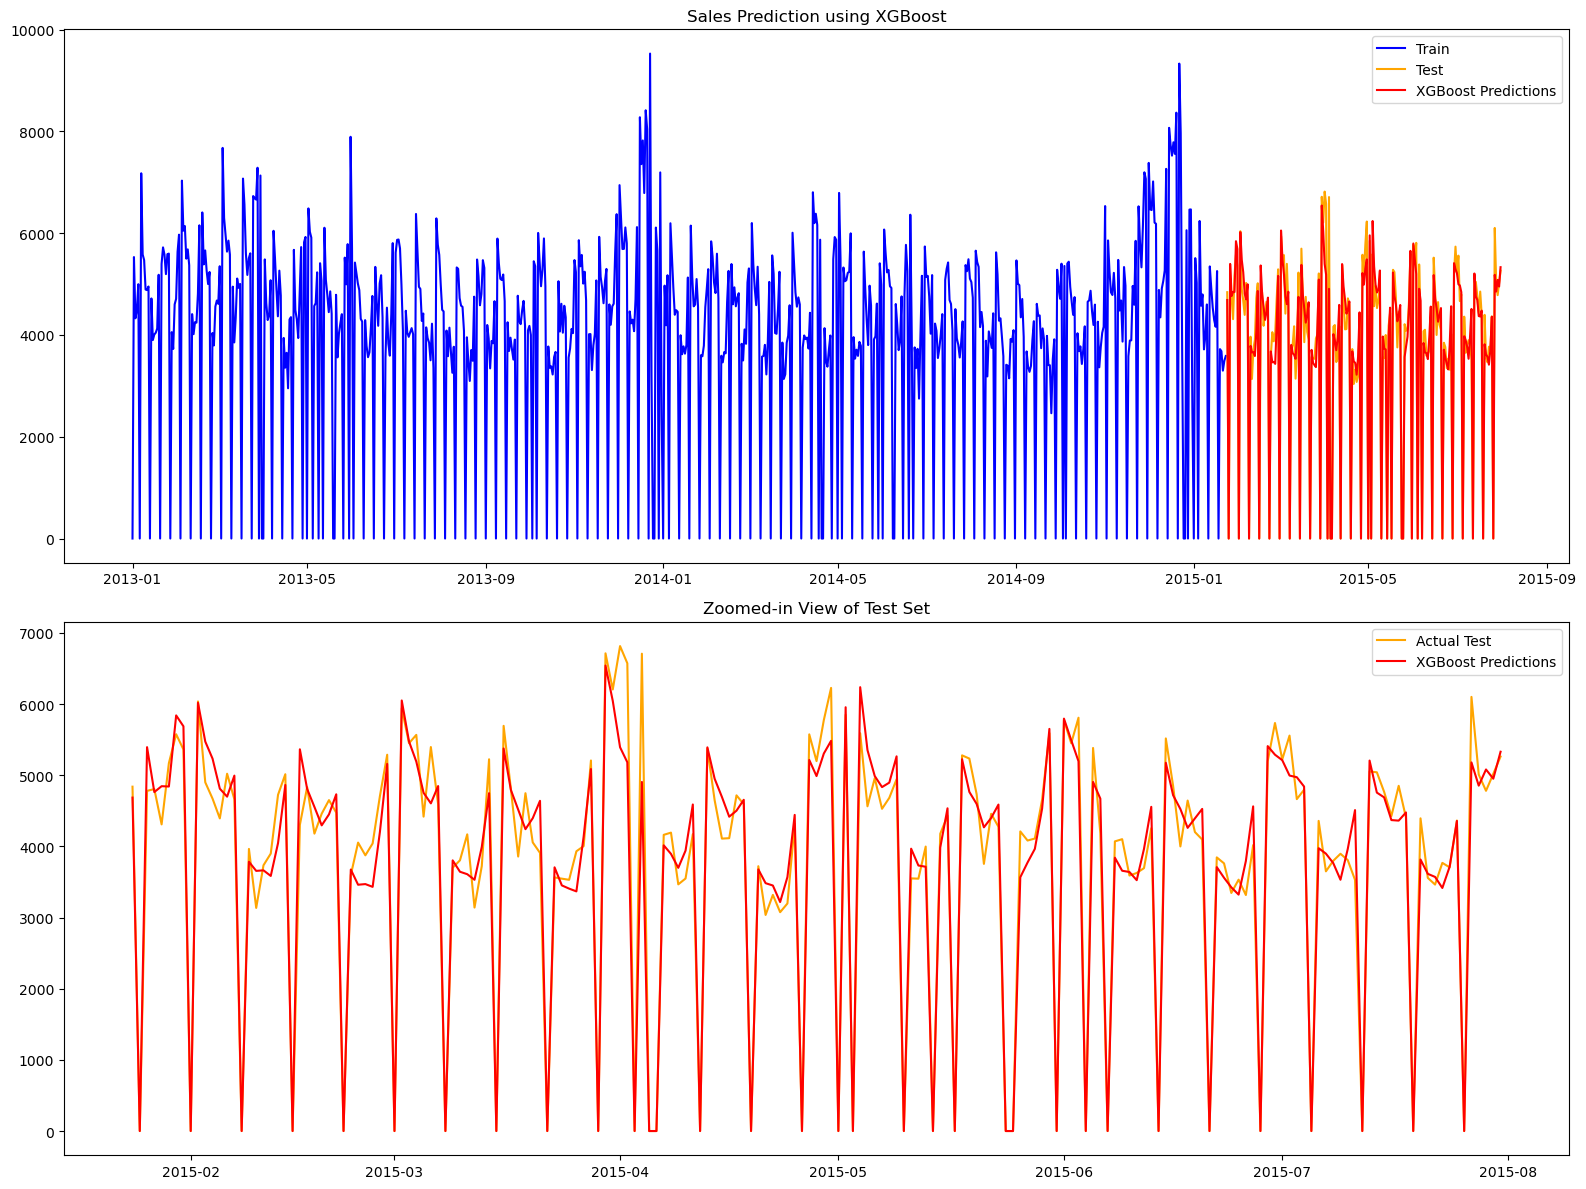

In [27]:
import matplotlib.pyplot as plt

# Plotting
fig, axes = plt.subplots(2, 1)
fig.set_figheight(12)
fig.set_figwidth(16)

# Plot for entire dataset
axes[0].plot(train_data["Sales"], label='Train', color='blue')
axes[0].plot(test_data["Sales"], label='Test', color='orange')
axes[0].plot(xgb_test_preds, label="XGBoost Predictions", color='red')
axes[0].legend(loc='best')
axes[0].set_title('Sales Prediction using XGBoost')

# Plot zoomed in on the test set
axes[1].plot(test_data["Sales"], label='Actual Test', color='orange')
axes[1].plot(xgb_test_preds, label="XGBoost Predictions", color='red')
axes[1].legend(loc='best')
axes[1].set_title('Zoomed-in View of Test Set')

plt.tight_layout()
plt.show()


---

# 8. <a name="8">**Best Mode**</a>
(<a href="#0">Go to top</a>)

## <font color='green'>**Best model: xgboost Regressor**</font>

# 9.<a name="8">**Kaggle submission**</a>
(<a href="#0">Go to top</a>)

In [88]:
# Create a submission file for Kaggle
submission_df = pd.DataFrame({"Id": range(1, len(xgb_test_preds) + 1), "Sales": xgb_test_preds.values})
submission_df.to_csv("submission.csv", index=False)